# What results to collect, and how

In this notebook we'll look at how to use `epydemic` to collect results from experiments. A lot of built-in processes do this automatically: we've already seen how the SIR process collects the final sizes of compartments. But what if we wanted to collect other information? There are essentially two approaches:

- analyse the final network after performing an experiment; or
- extend a process class to collect infortmation over the course of an experiment.

Each of these addresses a different use case, and in this notebook we'll look at each.

In [1]:
# numpy
import numpy
from numpy.random import default_rng

# simulation
from epyc import Experiment
from epydemic import ERNetwork, Percolate, StochasticDynamics, Process, ProcessSequence

# networks
import networkx
from collections import Counter

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## Analysing the final network

In many experiments what we're most interested in is something about the final state of the system.

As an example, suppose we're interested in communication systems. We have a network representing a communications network &ndash; some portion of the internet, let's say &ndash; and we want to see what happens if we remove a sizeable fraction of the links. Does the network stay fully connected? &ndash; and if not, what are the sizes of the component sub-networks thaat are left connected?

This is an example of a *percolation* process, where edges are retained in the network with a certain probability (called the *occupation probability*, the probability with which an edge remains actually occupied by a link after the process completes). We'll look at these processes in a lot more detail later: for the time being we note that `epydemic` has a suitable process built-in that will do the experiment for us.

To do the experiment, let's work with ER networks.

In [2]:
# the parameters of the network
N = int(1e4)
kmean = 10

# the occupation probability
T = 0.10                       # retain 10% of the edges

In [3]:
params = dict()
params[ERNetwork.N] = N
params[ERNetwork.KMEAN] = kmean
params[Percolate.T] = T

In [4]:
m = Percolate()
g = ERNetwork()
e = StochasticDynamics(m, g)

rc = e.set(params).run()

### Capturing the final network for analysis

The process ran, and presumably generated results -- although if we look in the results dict we'll see that there aren't any captured.

In [5]:
rc

{'parameters': {'N': 10000,
  'kmean': 10,
  'epydemic.percolate.T': 0.1,
  'topology': 'ER'},
 'metadata': {'epyc.experiment.classname': 'epydemic.stochasticdynamics.StochasticDynamics',
  'epyc.experiment.start_time': datetime.datetime(2023, 8, 4, 11, 9, 21, 107720),
  'epyc.experiment.setup_time': 0.230841,
  'epydemic.monitor.time': 0,
  'epydemic.monitor.events': 0,
  'epyc.experiment.experiment_time': 3e-05,
  'epyc.experiment.teardown_time': 8e-06,
  'epyc.experiment.end_time': datetime.datetime(2023, 8, 4, 11, 9, 21, 338599),
  'epyc.experiment.elapsed_time': 0.230879,
  'epyc.experiment.status': True},
 'results': {}}

The percolation process as defined doesn't generate any results: it's designed just to perform the random percolation of the network. But of course we ended up with a final network, whcih we can extract.

In [6]:
g_per = m.network()
print(g_per)

Graph with 10000 nodes and 5026 edges


We can analyse this network to determine the sizes of the connected components that remain after we removed so large a fraction of the edges. We dfo this using the `networkx.connected_components` function, which actually returns a list of components, each of which is a list of the nodes in that component. We can wrangle this a little to extract the number of components of a given size.

In [7]:
# extract the components
cs = networkx.connected_components(g_per)

# sort them into order of increasing size
cs_size = list(map(len, sorted(cs, key=len, reverse=False)))

# use a counter to sumarise the values
cn = Counter(cs_size)

print(cn)

Counter({1: 3647, 2: 679, 3: 270, 4: 123, 5: 62, 6: 36, 8: 29, 7: 28, 9: 19, 10: 17, 11: 8, 13: 6, 12: 5, 14: 5, 15: 5, 17: 5, 16: 4, 21: 4, 19: 3, 18: 2, 22: 2, 23: 2, 25: 2, 26: 2, 72: 2, 20: 1, 31: 1, 34: 1, 35: 1, 40: 1, 49: 1, 50: 1, 59: 1, 100: 1, 211: 1, 349: 1, 387: 1})


Plotting the data then gives the distribution of component sizes.

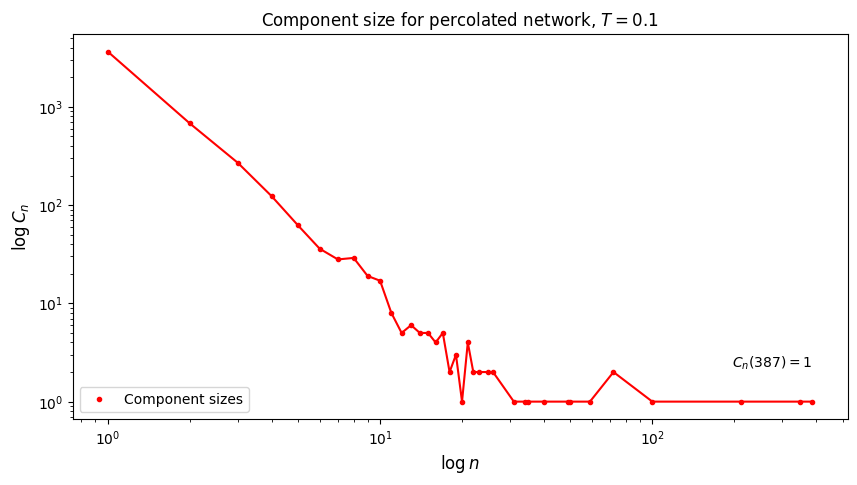

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# extract the component size histogram
cs = networkx.connected_components(g_per)
cs_size = list(map(len, sorted(cs, key=len, reverse=False)))
cn_min, cn_max = cs_size[0], cs_size[-1]
cn = Counter(cs_size)

# plot the component sizes
ax.plot(cn.keys(), cn.values(), 'r-')
ax.plot(cn.keys(), cn.values(), 'r.', label="Component sizes")
                        
# add size of largest components
ax.annotate(f'$C_n({cn_max}) = {cn[cn_max]}$', [cn_max, cn[cn_max]],
            [cn_max, cn[cn_max] * 2],
            horizontalalignment='right', verticalalignment='bottom')

# set title and axis limits
ax.set_title(f'Component size for percolated network, $T = {T}$')
ax.set_xlabel('$\\log n$')
ax.set_ylabel('$\\log C_n$')
ax.legend(loc='lower left')
ax.loglog()
plt.show()

Plotting the distribution on a log-log scale shows that the distribution of component sizes is exponential (the graph is a straight line until we get to small values, where random errors get accentuated as noise). The majority of components are small, but there is also a "long tail" of larger components.

### Why analysing outside an experiment may not be the best idea

In doing this analysis we first ran the experiment, then extracted its final network, and then counted the structures of interest within it. This is simple and straightforward, and works well a few experiments.

However, what if we wanted to run lots of experiments? &ndash; either to reduce the variance in a set of repeated results, or to study hjow the behaviour changes across a set of parameters? In that case we'd need to collect *all* the networks resulting from *all* the experiments in order to analyse them. That's potentially a lot of data to retain, and if we make use of cluster computing, it's data that has to be moved over a network. It's also an invitation to mistakes and poor data analysis practices.

### Automating end-of-experiment analysis

A better approach, then, is to automate the analysis. We can do this by extending the process that we want to run and overriding its `results` method to add the information we want to the results dict that's returned from the experiment. The final network will be discarded automatically by `epydemic` &ndash; and since these are often synthetic (random) networks anyway, we don't lose much information by doing this, and we'll have retained the parameters that were uised to instanciate the network along with the results anyway.

Let's do this with our experiment. We move the analytics code into the derived class and place a series into the results that we return. We use a series rather than a dict because `epyc` expects either single values or arrays in the results dict, so it's easier to provide a series with zeros for the sizes that have no components of that size.

In [9]:
class PercolateComponentSizes(Percolate):
    '''A percolation model that collects the final component size distribution
    of the network.'''
    
    # Results
    COMPONENT_SIZE_DIST = "component_size_distribution"
    
    def __init__(self):
        super().__init__()
        
    def results(self):
        '''Add the component size distribution as a series.
        
        :returns: a dict of results'''
        rc = super().results()
        
        # compute the count of component sizes
        cs = networkx.connected_components(g_per)
        cs_size = list(map(len, sorted(cs, key=len, reverse=False)))
        cn_min, cn_max = cs_size[0], cs_size[-1]
        cn = Counter(cs_size)

        # create a series for the data
        csa = [cn[n] for n in range(cn_max + 1)]
        rc[self.COMPONENT_SIZE_DIST] = csa
        
        return rc

We can run the experiment exactly as before, with our new model

In [10]:
m = PercolateComponentSizes()
g = ERNetwork()
e = StochasticDynamics(m, g)

rc = e.set(params).run()

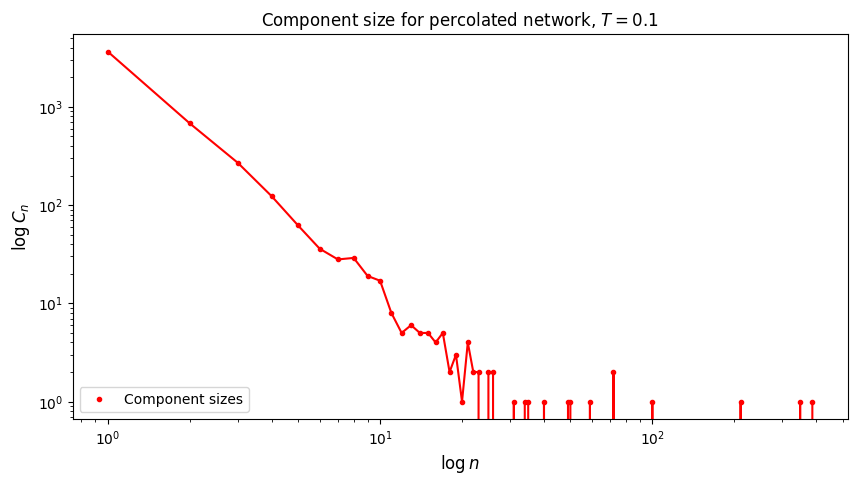

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# plot the component sizes
# (we jump past 0 because there can't be any empty components)
cn = rc[Experiment.RESULTS][PercolateComponentSizes.COMPONENT_SIZE_DIST]
ax.plot(range(1, len(cn)), cn[1:], 'r-')
ax.plot(range(1, len(cn)), cn[1:], 'r.', label="Component sizes")
                        
# set title and axis limits
ax.set_title(f'Component size for percolated network, $T = {T}$')
ax.set_xlabel('$\\log n$')
ax.set_ylabel('$\\log C_n$')
ax.legend(loc='lower left')
ax.loglog()
plt.show()

This makes little difference for our one experiment. But if we were to do thousands, the analysis would all happen automatically and exactly the same for each one. Moreover, if the experiments were done in parallel, the analysis would be too &ndash; useful if the analysis is itself computationally expensive!

There is a disadvantage too, of course: we had to create a new process class for the sole purpose of adding analytics to it. The "real work" of the process was untouched. As it happens there's a way to avoid this, by using process sequences.

### Separating analysis

The trick here is that `epydemic` allows several processes to be combined over the *same* network. That is to say, both proceses can create events, add and manipulate node state, and so forth &ndash; and both generate results. So we can take our normal percolation process as-is and define another process that simply extracts the statistics we want from the final network, which both processes share. Because the second (analysis) process doesn't define any events, it doesn't interact in any way with the running of the first (percolation) process.

Let's move the analysis into its own class.

In [18]:
class ComponentSizes(Process):
    '''A  process that collects the final component size distribution
    of the network.
    
    This process defines no events, and is intended to be used alongside
    other processes to collect end-state statistics.'''
    
    # Results
    COMPONENT_SIZE_DIST = "component_size_distribution"
    
    def __init__(self):
        super().__init__()
        
    def results(self):
        '''Add the component size distribution as a series.
        
        :returns: a dict of results'''
        rc = super().results()
        
        # compute the count of component sizes
        cs = networkx.connected_components(g_per)
        cs_size = list(map(len, sorted(cs, key=len, reverse=False)))
        cn_min, cn_max = cs_size[0], cs_size[-1]
        cn = Counter(cs_size)

        # create a series for the data
        csa = [cn[n] for n in range(cn_max + 1)]
        rc[self.COMPONENT_SIZE_DIST] = csa
        
        return rc

We then run an experiment consisting of the two processes collected within a `ProcessSequence` object. This combines all the set-up, tear-down, events, and results generation of each component process, running them over a shared network.

In [19]:
# original percolation process combined with the analysis class
m = ProcessSequence([Percolate(), ComponentSizes()])
g = ERNetwork()
e = StochasticDynamics(m, g)

rc = e.set(params).run()

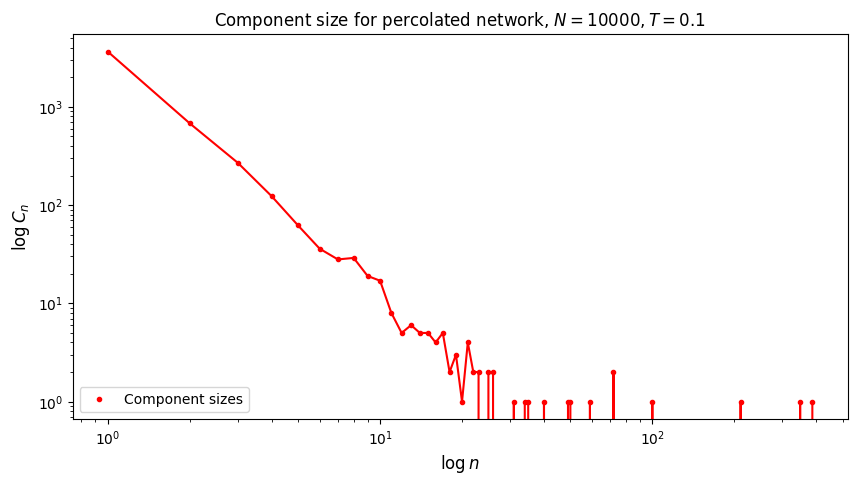

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# plot the component sizes
# (we jump past 0 because there can't be any empty components)
cn = rc[Experiment.RESULTS][PercolateComponentSizes.COMPONENT_SIZE_DIST]
ax.plot(range(1, len(cn)), cn[1:], 'r-')
ax.plot(range(1, len(cn)), cn[1:], 'r.', label="Component sizes")
                        
# set title and axis limits
ax.set_title(f'Component size for percolated network, $N = {N}, T = {T}$')
ax.set_xlabel('$\\log n$')
ax.set_ylabel('$\\log C_n$')
ax.legend(loc='lower left')
ax.loglog()
plt.show()

Incidentally, if all you're interested in is the size of the largest and next-to-largest connected components, then `epydemic` has a built-in process, `Statistics`, that collects these (and other) values.

## Tracking an experiment

The approaches above all waited until the end of an experiment before collecting results. The other major class of analytics works over the whole lifetime of the experiment, collecting information as we go. This can be really useful when seeing how the structure of the network changes during an experiment. We've seen how we can collect and represent series in `epyc`. We can use the same approach for this new kind of longitudinal analysis.

### Building a time series

Continuing with our communications network example, it might be interesting to see how the largest connected component (or *LCC*, sometimes also callled the *giant component*) breaks down as we remove random links. There are several ways we might do this, but for our percolation process the easiest way is to track the edges as they are removed and work out the largest component size at every few steps. Unfortunately the built-in `Percolate` class isn't amenable to this as it optimises the way it does percolation, so we'll have to build the process from scratch.

In [15]:
class PercolateLCC(Process):
    '''A process that bond percolates a network and counts the size
    of the largest component.
    '''

    # Experimental parameters
    T = Percolate.T
    STEP = "samplestep"

    # Results
    LCC = "lcc"

    def __init__(self):
        super().__init__()

    def percolate(self, T, step):
        '''Percolate the network.
        
        :param T: the occupation probability
        :param step: the sample step
        '''
        g = self.network()
        rng = default_rng()
    
        # create a list of edges
        es = list(g.edges())
        
        # determine those edges that are unoccupied
        unoccupied = []
        self._largest = []
        for e in es:
            if rng.random() > T:
                # edge should be removed
                unoccupied.append(e)
                
        # remove the edges, sampling the network as we go
        n = 0
        for e in unoccupied:
            g.remove_edge(*e)
            
            # sample if needed
            n += 1
            if n % step == 0:
                # sample the size of the largest component
                largest = max(map(len, networkx.connected_components(g)))
                self._largest.append(largest)
        
        # add the size of the largest component at the end
        if n % step != 0:
            largest = max(map(len, networkx.connected_components(g)))
            self._largest.append(largest)

    def build(self, params):
        '''Percolate the network.

        :param params: the experimental parameters'''
        super().build(params)

        # percolate the network
        T = params[self.T]
        step = params[self.STEP]
        self.percolate(T, step)
        
    def results(self):
        '''Generate the component size series.
        
        :returns: a dict of results'''
        rc = super().results()
        rc[self.LCC] = self._largest.copy()
        return rc

We'ver had to compromise in building this class, of course: we've gone back to combining analysis with function. Perhaps there's a better way to design the classes to avoid this? Or maybe the problem is with how we're doing percolation all in one go rather than using events?

In any case, we can now run the experiment and plot the resulting time series of LCC size.

In [16]:
params[PercolateLCC.STEP] = 100
m = PercolateLCC()
g = ERNetwork()
e = StochasticDynamics(m, g)

rc = e.set(params).run()

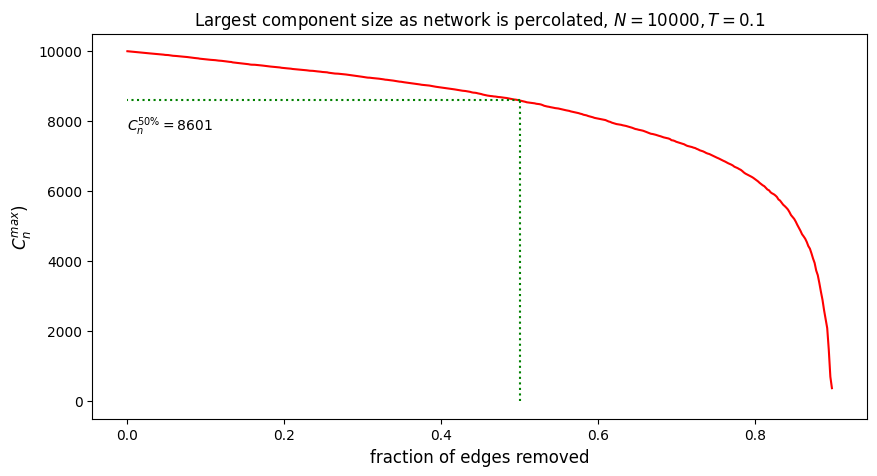

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# work out the fraction of edges removed at each step, as a range
cs = rc[Experiment.RESULTS][PercolateLCC.LCC]
fraction_removed_per_step = (1 - params[Percolate.T]) / len(cs)
fs = [fraction_removed_per_step * i for i in range(len(cs))]

# plot the largest component size
ax.plot(fs, cs, 'r-')
                        
# plot LCC size when 50% of edges have been removed
r50 = int(len(cs) / (1 - params[Percolate.T]) * 0.5)
cn50 = cs[r50]
ax.plot([0.5, 0.5], [0.0, cn50],
        color='green', linestyle='dotted')
ax.plot([0.5, 0.0], [cn50, cn50],
        color='green', linestyle='dotted')
ax.annotate('$C_n^{50\%} = ' + f'{cn50}$',[0.0, cn50],
            [0.0, cn50 * 0.9])

# set title and axis limits
ax.set_title(f'Largest component size as network is percolated, $N = {N}, T = {T}$')
ax.set_xlabel('fraction of edges removed')
ax.set_ylabel('$C_n^{max}$)')
plt.show()

Just for interest we've plotted the size of the LCC when 50% of the edges have been removed from the network. The network has stayed somewhat connected: around 85% of the nodes are within a single component even after removing half the connections.